# Charging Stations at EPFL (GreenMotion dataset)

In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.options.mode.chained_assignment = None  # default='warn', Mutes warnings when copying a slice from a DataFrame.
import math
from math import sqrt
import re
from datetime import datetime
from datetime import *

In [57]:
DATA_FOLDER = 'data'

### A. Loading phase
Load the EPFL charging stations excel file into a `DataFrames`. 

In [68]:
cs_dataframe = pd.read_excel("{}/EPFL-data-extract.xlsx".format(DATA_FOLDER), index_col=0) 

In [128]:
cs_dataframe.head()

,ChargingStationId,ChargingStationPlugId,BeginDate,EndDate,PowerConsumption,HashedUserId
ChargeLogId,,,,,,
4911,118,165,2013-11-22 09:02:37,2013-11-22 09:03:09,0,0x725B61EAA9973F5EF7FE6BE2033C5F264982C8C04ED3...
4912,118,166,2013-11-22 09:02:49,2013-11-22 09:03:21,0,0x70BD1D7BE1297329FE64409179DA9D1B789BE5283D0C...
4913,118,166,2013-11-22 09:08:29,2013-11-22 09:09:17,0,0x70BD1D7BE1297329FE64409179DA9D1B789BE5283D0C...
4914,118,166,2013-11-22 09:10:36,2013-11-22 09:10:54,0,0x70BD1D7BE1297329FE64409179DA9D1B789BE5283D0C...
4915,118,166,2013-11-22 09:11:57,2013-11-22 09:12:13,0,0x70BD1D7BE1297329FE64409179DA9D1B789BE5283D0C...


### B. Exploring the data

Useful functions:

In [182]:
def nb_minutes(EndDate, BeginDate):
    delta = EndDate - BeginDate
    nb_min_final_day = delta.seconds//60
    nb_days = delta.days
    nb_min = nb_min_final_day + nb_days*24*60 + 1
    return nb_min

Computing charging duration and power:

In [167]:
delta_vect = cs_dataframe.apply(lambda x : nb_minutes(x.EndDate, x.BeginDate), axis=1) #compute minutes of charge
cs_dataframe["ChargingDuration"] = delta_vect 
cs_dataframe["Power"] = cs_dataframe["PowerConsumption"] / cs_dataframe["ChargingDuration"] * 60 # compute power
cs_df = cs_dataframe.drop('HashedUserId', axis=1)
cs_df.head()

,ChargingStationId,ChargingStationPlugId,BeginDate,EndDate,PowerConsumption,ChargingDuration,Power
ChargeLogId,,,,,,,
4911,118,165,2013-11-22 09:02:37,2013-11-22 09:03:09,0,1,0.0
4912,118,166,2013-11-22 09:02:49,2013-11-22 09:03:21,0,1,0.0
4913,118,166,2013-11-22 09:08:29,2013-11-22 09:09:17,0,1,0.0
4914,118,166,2013-11-22 09:10:36,2013-11-22 09:10:54,0,1,0.0
4915,118,166,2013-11-22 09:11:57,2013-11-22 09:12:13,0,1,0.0


Let's remove unrealistic charging powers:

In [173]:
cs_df_clean = cs_df[cs_df.Power < 30000] # removing outliers (P>30kW...)

#### 1) At what time were built each stations? 

In [181]:
min_date = cs_df_clean.groupby('ChargingStationId').min().BeginDate
min_date

ChargingStationId
118    2013-11-22 09:02:37
577    2015-06-18 13:47:10
3391   2018-10-24 13:03:13
3392   2018-10-24 12:54:51
3398   2018-10-24 12:50:27
3399   2018-10-24 12:44:34
3413   2019-06-19 08:14:33
3461   2019-05-24 13:10:39
4743   2019-01-22 14:23:54
4744   2019-01-22 14:16:46
4745   2019-01-23 08:05:05
Name: BeginDate, dtype: datetime64[ns]

#### 2) What is the charging power of each station? 

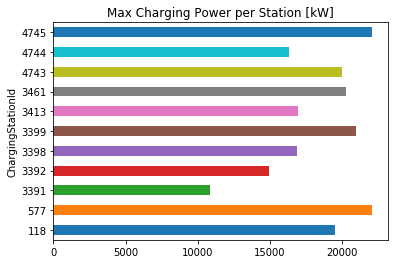

In [198]:
#compute mximum charging power
max_pow = cs_df_clean.groupby('ChargingStationId').max().Power.astype(int)
max_pow.plot(kind='barh', title='Max Charging Power per Station [kW]')

Apart from station 3391, all other stations seem to be able to charge above 11kW and below 22kW. 

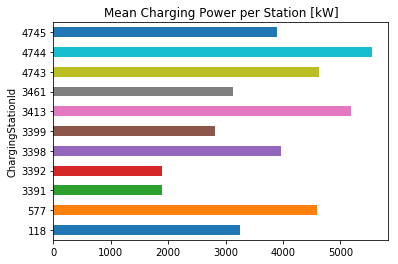

In [199]:
#compute average charging power
avg_pow = cs_df_clean.groupby('ChargingStationId').mean().Power.astype(int)
avg_pow.plot(kind='barh', title='Mean Charging Power per Station [kW]')

Most efficient charging stations seem to be **4744** and **3413** (P>5kW).   
Less efficient ones seem to be **3392** and **3391** (P<2kW).

### C) Charging power profile on 09/03/2020

In [287]:
#focusing data on 09/03/2020
df_2020_begin = cs_df_clean[cs_df_clean.BeginDate.dt.date == date(2020, 3, 9)]
df_2020 = df_2020_begin[df_2020_begin.EndDate.dt.date == date(2020, 3, 9)]
df_2020.head()

,ChargingStationId,ChargingStationPlugId,BeginDate,EndDate,PowerConsumption,ChargingDuration,Power
ChargeLogId,,,,,,,
711743,3392,4402,2020-03-09 12:49:43,2020-03-09 16:18:38,7650,209,2196.172249
711097,3413,4440,2020-03-09 05:13:41,2020-03-09 06:58:28,16805,105,9602.857143
711135,4745,5836,2020-03-09 05:33:25,2020-03-09 07:39:02,6578,126,3132.380952
711156,4743,5834,2020-03-09 07:58:24,2020-03-09 08:05:59,856,8,6420.000000
711399,3399,4409,2020-03-09 07:27:21,2020-03-09 11:56:52,8118,270,1804.000000


#### 1) Charging Power per Station

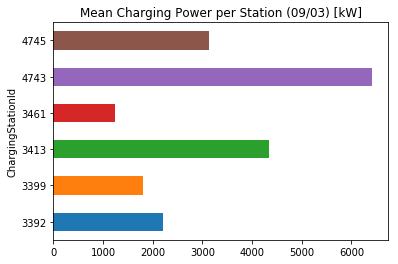

In [288]:
avg_pow_2020 = df_2020.groupby('ChargingStationId').mean().Power.astype(int)
avg_pow_2020.plot(kind='barh', title='Mean Charging Power per Station (09/03) [kW]')

#### 2) Creating hourly distribution

In [289]:
df_2020_new = df_2020
df_2020_new.BeginDate = df_2020.BeginDate.dt.hour
df_2020_new.EndDate = df_2020.EndDate.dt.hour + 1

distrib = np.zeros(24)
for i in df_2020_new.index:
    for h in range(df_2020_new.loc[i].BeginDate.astype(int), df_2020_new.loc[i].EndDate.astype(int)):
        distrib[h] = distrib[h] + df_2020_new.loc[i].Power

Text(0.5,0,'Time [h]')

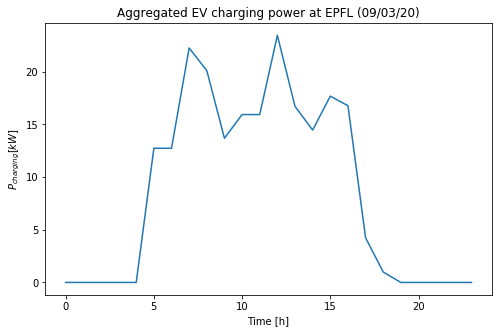

In [299]:
plt.figure(figsize=(8,5))
plt.plot(distrib/1000)
plt.title('Aggregated EV charging power at EPFL (09/03/20)')
plt.ylabel(r'$P_{charging} [kW]$')
plt.xlabel('Time [h]')
